In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


import yaml
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.stats import wstat
from gammapy.spectrum import SpectrumFit, CrabSpectrum
from gammapy.spectrum.models import SpectralModel
from scipy import stats
from tqdm import tqdm

from gammapy.spectrum import CountsPredictor

import emcee
import corner


import warnings
# from warnings import RuntimeWarning
# from astropy.utils.exceptions import AstropyWarning
# warnings.filterwarnings('error', category=AstropyWarning, append=True)

# warnings.filterwarnings('ignore', append=True)

from utils import load_spectrum_observations, Log10Parabola, plot_spectra

from IPython.display import display, Math

from scipy.stats import poisson, gamma
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from IPython.display import display, Math


# %load_ext autoreload
# %autoreload 2
%matplotlib inline

I plot the single fit results for the $\beta$ parameter including the estimated standard deviations from the output in the yaml files. This looks just like on would expect and totally fits the countour plots in the paper.


In [2]:
n_off = 2
b = 0.5*n_off
a = n_off * b +  1

mode = (a - 1) / b
mean = a / b
var = a / b**2

var, mode, mean

(3.0, 2.0, 3.0)

In [3]:
N = 70
stats.poisson.pmf(k=N, mu=N), stats.truncnorm.pdf(N, a=0, b=np.inf, loc=N, scale=10)

(0.04762599171586798, 0.07978845608028654)

In [56]:
gamma.pdf(-1, a=1)

0.0

In [340]:
def model_prediction(model, observation):
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
    counts *= observation.on_vector.areascal
    return counts.value

def get_mu_background(n_off, mu):
    mu_b = n_off + mu
    return np.where(mu_b < 0, 0, mu_b)

def ln_likelihood(theta, n_on, n_off, alpha):
#     mu_sig, mu_bkg = theta
#     with np.errstate(divide='ignore', invalid='ignore'):
#         a = n_on * np.log(mu_sig + alpha*mu_bkg)
#         b = n_off * np.log(mu_bkg)
    
#     likelihood = a + b - mu_sig - (alpha + 1)*mu_bkg
    
#     t = -2*alpha*mu_bkg - mu_sig
#     likelihood = np.where(n_off == 0,t + a, likelihood)
#     likelihood = np.where(n_on == 0, t + n_off*np.log(alpha) + b, likelihood)
#     likelihood = np.where((n_on == 0) & (n_off == 0), t, likelihood)


    mu_sig, mu_bkg = theta
    mu_bkg = get_mu_background(n_off, mu_bkg)
    with np.errstate(divide='ignore', invalid='ignore'):
        likelihood = -alpha*mu_bkg - mu_sig + n_on * np.log(mu_sig + alpha*mu_bkg)
  
    return np.where(np.isnan(likelihood), -np.inf, likelihood)
    

def ln_prior(theta, alpha, n_off):
    mu_sig, mu_bkg = theta
    mu_bkg = get_mu_background(n_off, mu_bkg)
    with np.errstate(divide='ignore', invalid='ignore'):

####  poisson prior
#         m = np.sqrt(alpha) / np.sqrt(mu_bkg * (alpha*mu_bkg + mu_sig))
#         print(m)

##### truncated gauss prior
        scale = np.sqrt(n_off + 1)
        a = -(n_off / scale)
        try:
            m = stats.truncnorm.pdf(mu_bkg, a=a, b=np.inf, loc=n_off, scale=scale)
        except ValueError:
#         this is a scipy bug. see https://stackoverflow.com/questions/46415854/using-numpy-broadcasting-with-scipy-truncnorm
            m = np.array([stats.truncnorm.pdf(mu, a=c, b=np.inf, loc=n, scale=s) for mu, c, n, s in zip(mu_bkg, a, n_off, scale)])
        m = np.log(m)


#### gamma prior
#         b = 0.3 * n_off
#         theta= 1 / b
#         a = n_off * b +  1
        
# #         b = 1
# #         theta = 1 / b
# #         a = n_off
        
#         m = gamma.pdf(mu_bkg, a=a, scale=theta)
#         m = np.log(m)
##### constnat prior
#         m = np.zeros_like(mu_sig)

    
        m = np.where(mu_sig < 0, -np.inf, m)
        m = np.where(mu_bkg < 0, -np.inf, m)
#         m[mu_sig < 0] = -np.inf
#         m[mu_bkg < 0] = -np.inf
#         print(m)

#     return np.where(mu_sig >= 0, np.log(np.sqrt(1/(mu_sig))), -np.inf) # jeffreys prior would be nice. but how?
    return m


def ln_prob(theta, n_on, n_off, alpha, return_posterior=False):
    
    prob = ln_likelihood(theta, n_on, n_off, alpha)

    if return_posterior:
        lp = ln_prior(theta, alpha, n_off)
        prob = prob + lp

#     return prob
    return np.where(np.isfinite(prob), prob, -np.inf)


def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]



def model_probability(theta, observations, return_posterior=False, fit_range=None):
    amplitude, alpha, beta = theta[0:3]
    if (alpha < 0) or ( alpha > 10) or (beta > 15) or (amplitude < 0):
        return -np.inf

    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    obs_probabilities = []
    start = 3
    for obs in observations:
        try:
            mu_sig = model_prediction(model, obs)
        except:
#             print('--xx'*20)
#             print(mu_sig)
            print(amplitude, alpha, beta)
        
        end = start + len(mu_sig) 
        mu_bkg = theta[start:end]
        start = end
        
        n_on=obs.on_vector.data.data.value
        n_off=obs.off_vector.data.data.value
        obs_alpha=obs.alpha
        if fit_range is not None:
            bins = obs.on_vector.energy.bins
            mu_sig, mu_bkg, n_on, n_off, obs_alpha = apply_range(mu_sig, mu_bkg, n_on, n_off, obs_alpha, bins=bins, fit_range=fit_range)

        prob = ln_prob((mu_sig, mu_bkg), n_on, n_off, obs_alpha, return_posterior=return_posterior).sum()            

        obs_probabilities.append(prob)
    prob = sum(obs_probabilities)
#     if not np.isfinite(prob):
#         print(prob, '----> ', theta)
    return prob

def lllprob(*x):
    c = model_probability(*x)
    if np.isinf(c):
        return -np.inf
    elif c <= 0:
        return -np.inf
    else:
        return np.log(c)

In [368]:
obs_list, fit_range = load_spectrum_observations('hess')
fit_range

<Quantity [ 0.5, 30. ] TeV>

In [369]:
# fit_range = [0.5, 11] * u.TeV
# fit_range

In [370]:
# params = np.array([3.8, 2.5, 0.3])
# mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
# theta = np.append(params, 9*np.concatenate(mu_bs))
# m = model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range)
# print(m)
# print('-=-=-=-=-'*10)
# theta = np.append(params, 9.05*np.concatenate(mu_bs))
# m = model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range)
# print(m)
# print('-=-=-=-=-'*10)
# params = np.array([4.03453150e+00,  1.72543679e+00,  7.07314068e-01])
# mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
# theta = np.append(params, np.concatenate(mu_bs))
# m = model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range)
# print(m)
print('-=-=-=-=-'*10)
params = np.array([4.03453150e+00,  1.72543679e+00,  7.07314068e-01])
mu_bs = [np.zeros(len(obs.off_vector.data.data.value)) for obs in obs_list]
theta = np.append(params, np.concatenate(mu_bs))
m = model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range)
print(m)
None

-=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=--=-=-=-=-
533.0451719210964


In [371]:
# posterior = []
# likelihood = []
# fs = np.linspace(0, 3, 300)
# for f in fs:
#     params = np.array([4.2, 2.58, 0.43])
#     mu_bs = [np.zeros(len(obs.off_vector.data.data.value)) for obs in obs_list]
#     theta = np.append(params, f*np.concatenate(mu_bs))
#     posterior.append(model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range))
#     likelihood.append(model_probability(theta, obs_list, return_posterior=False, fit_range=fit_range))

# plt.plot(fs, posterior, label='posterior')
# plt.plot(fs, likelihood, label='likelihood')
# # plt.yscale('log')
# plt.legend()


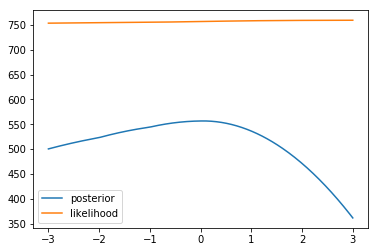

In [372]:
posterior = []
likelihood = []
fs = np.linspace(-3, 3, 300)
for f in fs:
    params = np.array([4.2, 2.58, 0.43])
#     mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
    mu_bs = [np.zeros(len(obs.off_vector.data.data.value)) for obs in obs_list]
#     mu_bs = np.zeros(len(obs_list))
    theta = np.append(params, f + np.concatenate(mu_bs))
    posterior.append(model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range))
    likelihood.append(model_probability(theta, obs_list, return_posterior=False, fit_range=fit_range))

plt.plot(fs, posterior, label='posterior')
plt.plot(fs, likelihood, label='likelihood')
# plt.yscale('log')
plt.legend()


In [373]:
N = 20
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

zs = []
zs_post = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
#     t1 = [3.8, alpha, beta]
#     tb = np.random.poisson(obs.background_vector.data.data.value.astype(np.int))
    params = np.array([3.8, alpha, beta])
#     mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
    mu_bs = [np.zeros(len(obs.off_vector.data.data.value)) for obs in obs_list]
    theta = np.append(params, np.concatenate(mu_bs))
    zs.append(model_probability(theta, obs_list, fit_range=fit_range))
    
    params = np.array([3.8, alpha, beta])
#     mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
    mu_bs = [np.zeros(len(obs.off_vector.data.data.value)) for obs in obs_list]
    theta = np.append(params, np.concatenate(mu_bs))
    zs_post.append(model_probability(theta, obs_list, return_posterior=True, fit_range=fit_range))

zs = np.array(zs)
zs_post = np.array(zs_post)


400it [00:08, 45.85it/s]


Text(0, 0.5, 'beta')

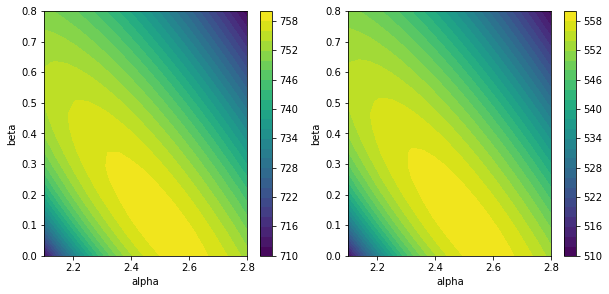

In [374]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
# ax1.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

cf = ax2.contourf(a, b, zs_post.reshape(len(a), -1), levels=24)
plt.colorbar(cf, ax=ax2)
# ax2.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')


In [375]:
# x0 = np.append([3.8, 2.6, 0.4], )
params = np.array([4.2, 2.58, 0.43])
# mu_bs = [obs.off_vector.data.data.value.astype(np.int) for obs in obs_list]
mu_bs = [np.zeros(len(obs.off_vector.data.data.value)) for obs in obs_list]
theta = np.append(params, np.concatenate(mu_bs))

bounds = [(0, 100) for t in theta]
options = {'maxiter': 500, 'disp' : True}

result = minimize(lambda *x: -lllprob(*x), x0=theta, args=(obs_list, True, fit_range), options=options)
result

Optimization terminated successfully.
         Current function value: -6.337777
         Iterations: 171
         Function evaluations: 51275
         Gradient evaluations: 175


      fun: -6.337777229782107
 hess_inv: array([[25.88772151, -1.17999891,  6.52380957, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17999891,  6.57389121, -7.49972906, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.52380957, -7.49972906, 13.0565418 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])
      jac: array([-2.50339508e-06, -1.54972076e-06, -2.20537186e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000

In [376]:
labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    txt = f"\mathrm{{{labels[i]}}} = {result.x[i]}"
#     print(labels[i], result.x[i])
#     txt = txt.format(labels[i], result.x[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [377]:
ndim, nwalkers = len(theta), 2*len(theta)
print(ndim, nwalkers)

pos = np.array([result.x + 0.005 * np.random.randn(ndim) for i in range(nwalkers)])
# pos = np.array([result.x + 0.005 * np.random.randn(ndim) for i in range(nwalkers)])
# pos = np.where(pos < 0.5, 1, pos)
# print(pos)
from multiprocessing import Pool
with Pool(processes=20) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model_probability, args=(obs_list, True, fit_range), pool=pool)
    sampler_output = sampler.run_mcmc(pos, 1000, progress=True)

291 582


100%|██████████| 1000/1000 [11:55<00:00,  1.21it/s]


Number of params/dims: 291
shape of samples: (582, 1000, 291)


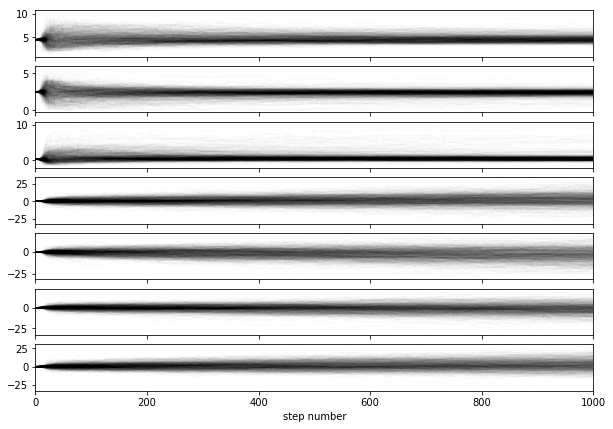

In [378]:
print(f'Number of params/dims: {ndim}')
print(f'shape of samples: {sampler.chain.shape}')
N = 7
fig, axes = plt.subplots(N, figsize=(10, N), sharex=True)
# labels = ["amplitude", "alpha", "beta"]
for i in range(N):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, "k", alpha=0.01)
    ax.set_xlim(0, len(sampler.chain[0]))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");


In [379]:
# sampler.get_autocorr_time(quiet=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

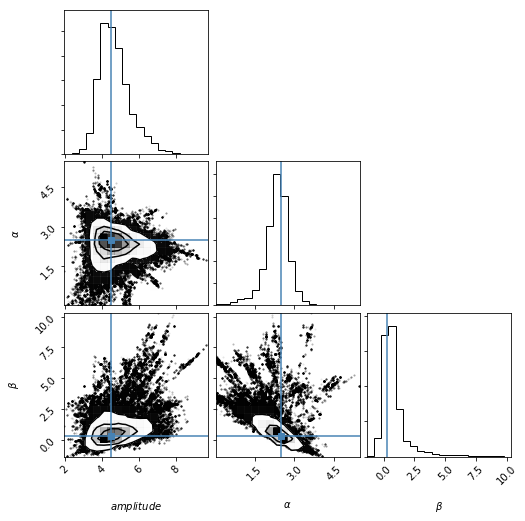

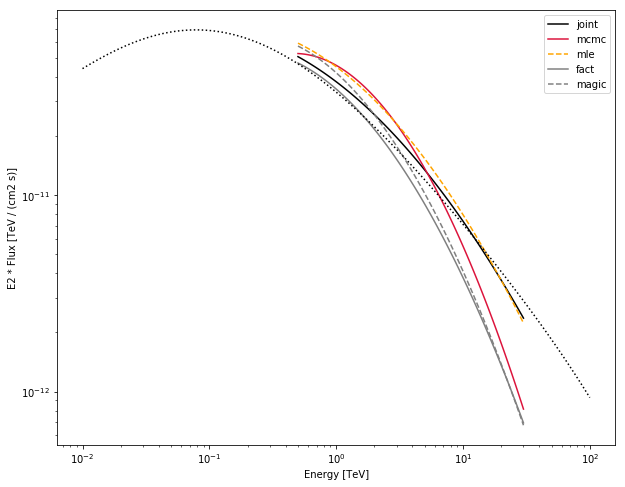

In [381]:
lowest_sample = 100
N = 3
fig = corner.corner(sampler.chain[:, lowest_sample:, :N].reshape([-1, 3]), labels=["$amplitude$", "$\\alpha$", "$\\beta$"], truths=result.x)

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, lowest_sample:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    txt = f"\mathrm{{MLE {labels[i]}}} = {result.x[i]}"
    display(Math(txt))

plt.figure(figsize=(10, 8))
plot_spectra(sampler, result, fit_range=fit_range, min_sample=lowest_sample)
plt.legend()

In [ ]:
lowest_sample = 3000
N = 3
fig = corner.corner(sampler.chain[:, lowest_sample:, :N].reshape([-1, 3]), labels=["$amplitude$", "$\\alpha$", "$\\beta$"], truths=result.x)

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, lowest_sample:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

plt.figure(figsize=(10, 8))
plot_spectra(sampler, result, fit_range=fit_range, min_sample=lowest_sample)
plt.legend()